In [1]:
#a triplet loss based training. It failed to produce good results.

import json
import os

data = {}
dataroot = "awe"

for i in range(1,101):
    with open(os.path.join(dataroot,str(i).zfill(3),"annotations.json")) as f:
        data[str(i).zfill(3)] = json.load(f)

In [2]:
print(list(data.keys()).index("004"))

3


In [3]:
#definition of our dataset. Returns triplets of images, two of same person and one of another

from torch.utils.data import Dataset, DataLoader
from itertools import combinations,permutations
import random
from skimage import io, color
from skimage.transform import rescale
from skimage.util import pad
from torchvision import transforms
from torchvision.transforms.functional import pad

imgsize = 128

class EarDataset(Dataset):
    """Ear dataset."""
    
    
    def __init__(self, root_dir, data, values=range(10)):

        #self.data = data
        #self.dataroot = root_dir
        
        self.data = []
        
        for num, i in enumerate(data):
            
            root = os.path.join(root_dir,i)
            imgdirs = []
            for num, j in enumerate(data[i]["data"]):
                if num not in values:
                    continue
                imgdirs.append(os.path.join(root,data[i]["data"][j]["file"]))
            comb = list(permutations(imgdirs,2))
            #comb[0] = list(comb[0])
            
            for j in range(len(comb)):
                comb[j] = list(comb[j])
                #randi = i
                #while(randi==i or list(data.keys()).index(randi) not in values):
                #    randi = random.choice(list(data.keys()))
                #randj = random.choice(list(data[randi]["data"].keys()))
                #comb[j].append(os.path.join(root_dir,randi,data[randi]["data"][randj]["file"]))
                
            
            self.data.append(comb)

        print(len(self.data),len(self.data[0]))

    def __len__(self):
        return len(self.data) * len(self.data[0])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        j = int(idx%len(self.data[0]))
        i = int(idx/len(self.data[0]))
        
        randi = i
        while(randi==i):
            randi = random.randint(0,len(self.data))
        randj = random.randint(0,len(self.data[0]))
                
        image1 = io.imread(self.data[i][j][0])
        image2 = io.imread(self.data[i][j][1])
        imager = io.imread(self.data[randi-1][randj-1][0])
        
        #print(image1.dtype)

        if len(image1.shape) == 2:
            image1 = color.gray2rgb(image1)
        elif image1.shape[2] == 4:
            image1 = image1[:,:,:3]
        if len(image2.shape) == 2:
            image2 = color.gray2rgb(image2)
        elif image2.shape[2] == 4:
            image2 = image2[:,:,:3]
        if len(imager.shape) == 2:
            imager = color.gray2rgb(imager)
        elif imager.shape[2] == 4:
            imager = imager[:,:,:3]
    
        image1 = rescale(image1,imgsize/image1.shape[0],multichannel = True)
        image2 = rescale(image2,imgsize/image2.shape[0],multichannel = True)
        imager = rescale(imager,imgsize/imager.shape[0],multichannel = True)
        
        #image1r = pad(image1,100)
        #print(image1r.shape,image1.shape)
        
    
        return image_transform(image1).type(torch.FloatTensor)[:,:,:128], image_transform(image2)[:,:,:128].type(torch.FloatTensor), image_transform(imager).type(torch.FloatTensor)[:,:,:128]
        
image_transform = transforms.Compose([
        #transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Pad((0,0,128,0)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [4]:
import torch

dataset_train = EarDataset(dataroot,data,values=range(0,7))
dataset_loader_train = torch.utils.data.DataLoader(dataset_train,
                                             batch_size=4, shuffle=True,
                                             num_workers=4)
dataset_test = EarDataset(dataroot,data,values=range(7,10))
dataset_loader_valid = torch.utils.data.DataLoader(dataset_test,
                                             batch_size=32, shuffle=True,
                                             num_workers=4)

100 42
100 6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


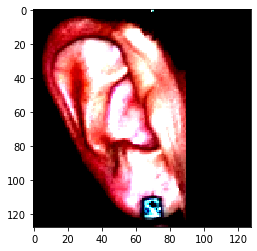

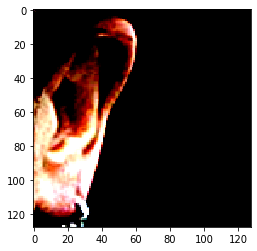

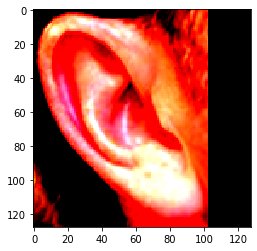

In [5]:
import matplotlib.pyplot as plt
import numpy as np

for i in dataset_loader_train:
    #print(i[0].shape)
    plt.figure()
    plt.imshow(i[0][0].permute(1,2,0))
    plt.figure()
    plt.imshow(i[1][0].permute(1,2,0))
    plt.figure()
    plt.imshow(i[2][0].permute(1,2,0))
    break

In [6]:
import torchvision.models as models
import torch.nn as nn
from torchsummary import summary


net = models.resnet50(pretrained=True)
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 128)
net.cuda()
#summary(resnet50,(3,128,60))

criterion = nn.TripletMarginLoss(margin=0.2).cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [7]:
import time
from tqdm import tqdm

losses_train = []
losses_valid = []

def train_model(model, criterion, optimizer, num_epochs=2, validation=False):
    since = time.time()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train','valid']:
            
            if phase == 'train':
                if validation:
                    continue
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            print("Starting phase: ", phase)
            running_loss = 0.0    
            running_eucp = 0.0
            running_eucn = 0.0
            # Iterate over data.
            dataload = dataset_loader_train if phase == 'train' else dataset_loader_valid
            for stuff in tqdm(dataload):
                
                image1,image2,imager = stuff
                
                image1 = image1.cuda()
                image2 = image2.cuda()
                imager = imager.cuda()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs1 = model(image1)
                #Swith torch.set_grad_enabled(False):
                    outputs2 = model(image2)
                    outputsr = model(imager)
                    loss = criterion(outputs1, outputs2, outputsr)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    

                # statistics
                running_loss += loss.item() #* images.size(0)
                running_eucp += calc_euclidean(outputs1.cpu().detach().numpy(),outputs2.cpu().detach().numpy())
                running_eucn += calc_euclidean(outputs1.cpu().detach().numpy(),outputsr.cpu().detach().numpy())
                
            epoch_loss = running_loss / len(dataload.dataset)
            epoch_eucp = running_eucp / len(dataload.dataset)
            epoch_eucn = running_eucn / len(dataload.dataset)
            
            if(phase == 'train'):
                losses_train.append(epoch_loss)
            else:
                losses_valid.append(epoch_loss)
            #epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Eucp: {:.4f} Eucn: {:.4f}'.format(
                phase, epoch_loss, epoch_eucp, epoch_eucn))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    #print('Best val Acc: {:4f}'.format(best_acc))

    return model

In [8]:
def calc_euclidean(x1, x2):
        return np.square(np.sum(x1 - x2))

In [9]:
net = net.cuda()
net = train_model(net, criterion, optimizer, num_epochs=10)

  0%|          | 0/1050 [00:00<?, ?it/s]

Epoch 0/9
----------
Starting phase:  train


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.0887 Eucp: 2.7556 Eucn: 3.1005
Starting phase:  valid


  0%|          | 0/1050 [00:00<?, ?it/s]

valid Loss: 0.0111 Eucp: 1.3994 Eucn: 1.7987
Epoch 1/9
----------
Starting phase:  train


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.0502 Eucp: 1.0073 Eucn: 1.2138
Starting phase:  valid


  0%|          | 0/1050 [00:00<?, ?it/s]

valid Loss: 0.0060 Eucp: 0.0163 Eucn: 0.0261
Epoch 2/9
----------
Starting phase:  train


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.0403 Eucp: 0.4096 Eucn: 0.6365
Starting phase:  valid


  0%|          | 0/1050 [00:00<?, ?it/s]

valid Loss: 0.0065 Eucp: 0.0403 Eucn: 0.0500
Epoch 3/9
----------
Starting phase:  train


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.0351 Eucp: 0.3627 Eucn: 0.6838
Starting phase:  valid


  0%|          | 0/1050 [00:00<?, ?it/s]

valid Loss: 0.0051 Eucp: 0.0986 Eucn: 0.0688
Epoch 4/9
----------
Starting phase:  train


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.0355 Eucp: 0.4820 Eucn: 1.1511
Starting phase:  valid


  0%|          | 0/1050 [00:00<?, ?it/s]

valid Loss: 0.0058 Eucp: 0.1601 Eucn: 0.4190
Epoch 5/9
----------
Starting phase:  train


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.0354 Eucp: 0.4947 Eucn: 1.0878
Starting phase:  valid


  0%|          | 0/1050 [00:00<?, ?it/s]

valid Loss: 0.0071 Eucp: 1.0033 Eucn: 0.9816
Epoch 6/9
----------
Starting phase:  train


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.0418 Eucp: 0.4501 Eucn: 0.7402
Starting phase:  valid


  0%|          | 0/1050 [00:00<?, ?it/s]

valid Loss: 0.0054 Eucp: 0.4558 Eucn: 1.2892
Epoch 7/9
----------
Starting phase:  train


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.0330 Eucp: 0.4066 Eucn: 0.8985
Starting phase:  valid


  0%|          | 0/1050 [00:00<?, ?it/s]

valid Loss: 0.0062 Eucp: 0.7355 Eucn: 2.0895
Epoch 8/9
----------
Starting phase:  train


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.0310 Eucp: 0.2327 Eucn: 0.5342
Starting phase:  valid


  0%|          | 0/1050 [00:00<?, ?it/s]

valid Loss: 0.0047 Eucp: 0.0387 Eucn: 0.2125
Epoch 9/9
----------
Starting phase:  train


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.0308 Eucp: 0.1348 Eucn: 0.3408
Starting phase:  valid


100%|██████████| 19/19 [00:02<00:00,  7.08it/s]

valid Loss: 0.0044 Eucp: 0.0561 Eucn: 0.1796
Training complete in 18m 38s


In [68]:
print(epoch_loss)

NameError: name 'epoch_loss' is not defined

In [13]:
cr = 0
wr = 0

for stuff in tqdm(dataset_loader_train):    
    
    image1,image2,imager = stuff

    image1 = image1.cuda()
    image2 = image2.cuda()
    imager = imager.cuda()

    with torch.set_grad_enabled(False):
        outputs1 = net(image1)
        outputs2 = net(image2)
        outputsr = net(imager)
    
    for i in range(outputs1.shape[0]):
        eucp = calc_euclidean(outputs1[i].cpu().detach().numpy(),outputs2[i].cpu().detach().numpy())
        eucn = calc_euclidean(outputs1[i].cpu().detach().numpy(),outputsr[i].cpu().detach().numpy())
        if eucp >= eucn:
            wr +=1
        else:
            cr +=1

print(cr,wr)


100%|██████████| 1050/1050 [00:31<00:00, 33.32it/s]

2804 1396
